In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import os
import tifffile as tiff

import cv2 as cv
from scipy import ndimage as ndi

In [2]:
# criando o path de ler imagem, localizado em tests/data/galaxy

current_path = os.getcwd()
# subindo uma folder para acessar a pasta data
current_path = os.path.abspath(os.path.join(current_path, os.pardir))
# descendo um folder para data/galaxy
current_path = os.path.join(current_path, 'data', 'galaxy')
# acessando o arquivo arq220.tif
img_path = 'teste.tif'


path = os.path.join(current_path, img_path)

# lendo a imagem 'quintet.tif'
img = tiff.imread(path)

In [3]:
img.dtype

dtype('uint8')

## fazendo filtro passa banda

In [4]:
class BandPassFilter:
    def __init__(self, input_img, f_max, f_min, **kwargs):
        """Class to apply the band pass filter to an image

        Args:
            input_img (uint8): Input image to apply the filter, the JWST image after the preprocessing pipeline
            f_max (float): max frequency to pass the filter
            f_min (float): min frequency to pass the filter
            alfa (float, optional): Weight of the input image in the blending. Defaults to 0.5.
            beta (float, optional): Weight of the Sobel filter in the blending. Defaults to 0.5.
            dpi (int, optional): DPI of the plots. Defaults to 100.
            img_show_tuple (tuple, optional): Size of the plots. Defaults to (10, 10).
            gausian_sigma (int, optional): Sigma of the Gaussian filter applied to the mask. Defaults to 5.
            skleton_treshold (int, optional): Treshold of the skeletonization. Defaults to 127.
            skleton_morphology (int, optional): Morphology of the skeletonization. Defaults to cv.MORPH_CROSS.
            skleton_kernel (np.array, optional): Kernel of the skeletonization. Defaults to np.ones((3, 3), np.uint8).
            save_img (bool, optional): Save the images that were plotted. Defaults to False.
            rgb (tuple, optional): rgb of the skeletonized Sobel filter. Defaults to (0, 255, 0).
            plot_input_img (bool, optional): Plot the input image. Defaults to True.
            plot_gray_img (bool, optional): Plot the grayscale image. Defaults to False.
            plot_magnitude_spectrum (bool, optional): Plot the magnitude spectrum. Defaults to False.
            plot_horizontal_profile (bool, optional): Plot the horizontal profile. Defaults to False.
            plot_mask_img (bool, optional): Plot the mask. Defaults to False.
            plot_back_img (bool, optional): Plot the image back. Defaults to False.
            plot_sobel_img (bool, optional): Plot the Sobel filter. Defaults to False.
            plot_blended_img (bool, optional): Plot the blended image. Defaults to True.
            plot_all (bool, optional): Plot all the images. Defaults to False.
            return_input_img (bool, optional): Return the input image. Defaults to False.
            return_gray_img (bool, optional): Return the grayscale image. Defaults to False.
            return_magnitude_spectrum (bool, optional): Return the magnitude spectrum. Defaults to False.
            return_horizontal_profile (bool, optional): Return the horizontal profile. Defaults to False.
            return_mask_img (bool, optional): Return the mask. Defaults to False.
            return_back_img (bool, optional): Return the image back. Defaults to False.
            return_sobel_img (bool, optional): Return the Sobel filter. Defaults to False.
            return_blended_img (bool, optional): Return the blended image. Defaults to False.
        Returns:
            np.array: are optional, if the user wants to return the images. If the argument (as show in the Args) is True, the function will return the image.
            For the images:
                - gray_img: Grayscale image
                - magnitude_spectrum: Magnitude spectrum
                - mask_img: Mask
                - img_back: Image back
                - mag: Sobel filter
            While returning them, plot all with cmap="gray"
            Also, when returning more than one image, they will be returned in the same order as the Args
        """
        self.input = np.array(input_img)
        self.fmax = f_max
        self.fmin = f_min
        self.alfa = kwargs.get("alfa", 0.5)
        self.beta = kwargs.get("beta", 0.5)
        self.dpi = kwargs.get("dpi", 100)
        self.img_show_tuple = kwargs.get("img_show_tuple", (10, 10))
        self.gausian_sigma = kwargs.get("gausian_sigma", 5)
        self.skleton_treshold = kwargs.get("skleton_treshold", 127)
        self.skleton_morphology = kwargs.get("skleton_morphology", cv.MORPH_CROSS)
        self.skleton_kernel = kwargs.get("skleton_kernel", np.ones((3, 3), np.uint8))
        self.save_img = kwargs.get("save_img", False)
        self.rgb = kwargs.get("rgb", (0, 255, 0))
        self.plot_input_img = kwargs.get("plot_input_img", True)
        self.plot_gray_img = kwargs.get("plot_gray_img", False)
        self.plot_magnitude_spectrum = kwargs.get("plot_magnitude_spectrum", False)
        self.plot_horizontal_profile = kwargs.get("plot_horizontal_profile", False)
        self.plot_mask_img = kwargs.get("plot_mask_img", False)
        self.plot_back_img = kwargs.get("plot_back_img", False)
        self.plot_sobel_img = kwargs.get("plot_sobel_img", False)
        self.plot_blended_img = kwargs.get("plot_blended_img", True)
        self.return_input_img = kwargs.get("return_input_img", False)
        self.return_gray_img = kwargs.get("return_gray_img", False)
        self.return_magnitude_spectrum = kwargs.get("return_magnitude_spectrum", False)
        self.return_horizontal_profile = kwargs.get("return_horizontal_profile", False)
        self.return_mask_img = kwargs.get("return_mask_img", False)
        self.return_back_img = kwargs.get("return_back_img", False)
        self.return_sobel_img = kwargs.get("return_sobel_img", False)
        self.return_blended_img = kwargs.get("return_blended_img", False)

    def gray(self):
        """Convert the input image to grayscale"""
        self.gray_img = cv.cvtColor(self.input, cv.COLOR_BGR2GRAY)

    def fourier(self):
        """Apply the fourier transform to the grayscale image"""
        f_transform = np.fft.fft2(self.gray_img)
        self.f_transform = np.fft.fftshift(f_transform)

        magnitude_spectrum = np.abs(self.f_transform)
        magnitude_spectrum = np.log(1 + magnitude_spectrum)
        self.magnitude_spectrum = magnitude_spectrum

    def horizontal_profile(self):
        """Get the horizontal profile of the magnitude spectrum"""
        height, _ = self.magnitude_spectrum.shape
        horizontal_profile = self.magnitude_spectrum[height // 2, :]
        self.horizontal_profile = horizontal_profile

    def mask(self):
        """Create the mask to apply to the fourier transform"""
        self.rows, self.cols = self.gray_img.shape
        crow, ccol = self.rows // 2, self.cols // 2
        mask = self.magnitude_spectrum.copy()

        l, c = np.indices((self.rows, self.cols))
        distances = np.hypot((l - crow), (c - ccol))
        mask = np.where((distances > self.fmax) | (distances < self.fmin), 0, mask)
        # Applying Gaussian smoothing to the mask
        self.mask_img = ndi.gaussian_filter(mask, sigma=self.gausian_sigma)

    def fourier_inverse(self):
        """Apply the inverse fourier transform to the mask"""
        self.f_transform *= self.mask_img
        f_ishift = np.fft.ifftshift(self.f_transform)
        img_back = np.fft.ifft2(f_ishift)
        self.img_back = np.abs(img_back)

    def sobel(self):
        """Apply the Sobel filter to the image back"""
        dx = ndi.sobel(self.img_back, 0)
        dy = ndi.sobel(self.img_back, 1)
        mag = np.hypot(dx, dy)
        mag *= 255.0 / np.max(mag)
        self.mag = mag

    def skeletonize(self):
        """Skeletonize the Sobel filter"""
        _, img = cv.threshold(self.mag, 50, 255, 0)

        skel = np.zeros(img.shape, np.uint8)
        while True:
            # Get a Cross Shaped Kernel
            element = cv.getStructuringElement(cv.MORPH_CROSS, (11, 11))
            # Step 2: Open the image
            open = cv.morphologyEx(img, cv.MORPH_OPEN, element)
            # Step 3: Substract open from the original image
            temp = cv.subtract(img, open)
            # Step 4: Erode the original image and refine the skeleton
            eroded = cv.erode(img, element)
            img = eroded.copy()
            skel = cv.bitwise_or(skel, temp.astype(np.uint8))
            if cv.countNonZero(img) == 0:
                break

        # dilating the skeleton
        skel = cv.dilate(skel, self.skleton_kernel, iterations=1)
        self.skel = skel

    def blend(self):
        """Blend the input image with the skeletonized Sobel filter"""
        bgr_image = np.zeros(
            (self.skel.shape[0], self.skel.shape[1], 3), dtype=np.uint8
        )
        bgr_image[:, :, 0] = np.where(self.skel == 255, self.rgb[0], 0)
        bgr_image[:, :, 1] = np.where(self.skel == 255, self.rgb[1], 0)
        bgr_image[:, :, 2] = np.where(self.skel == 255, self.rgb[2], 0)
        img_array = self.input.astype(np.uint8)
        self.blended = cv.addWeighted(img_array, self.alfa, bgr_image, self.beta, 0)

    def plot_input(self):
        """Plot the input image"""
        plt.figure(figsize=self.img_show_tuple, dpi=self.dpi)
        plt.title("Input image")
        plt.imshow(self.input)
        if self.save_img and self.plot_input_img:
            plt.savefig("input.png")
        plt.axis("off")

    def plot_gray(self):
        """Plot the grayscale image"""
        plt.figure(figsize=self.img_show_tuple, dpi=self.dpi)
        plt.title("Grayscale image")
        plt.imshow(self.gray_img, cmap="gray")
        if self.save_img and self.plot_gray_img:
            plt.savefig("gray.png")
        plt.axis("off")

    def plot_magnitude(self):
        """Plot the magnitude spectrum"""
        plt.figure(figsize=self.img_show_tuple, dpi=self.dpi)
        plt.title("Magnitude Spectrum")
        plt.imshow(self.magnitude_spectrum, cmap="gray")
        plt.axis("off")
        if self.save_img and self.plot_magnitude_spectrum:
            plt.savefig("magnitude.png")
        plt.show()

    def plot_horizontal(self):
        """Plot the horizontal profile"""
        plt.figure(figsize=self.img_show_tuple, dpi=self.dpi)
        plt.plot(self.horizontal_profile)
        plt.title("Horizontal profile")
        plt.xlabel("frequency")
        plt.ylabel("magnitude")
        if self.save_img and self.plot_horizontal_profile:
            plt.savefig("horizontal_profile.png")
        plt.show()

    def plot_mask(self):
        """Plot the mask"""
        plt.figure(figsize=self.img_show_tuple, dpi=self.dpi)
        plt.title("Mask - Pass Band")
        plt.imshow(np.abs(self.mask_img), cmap="gray")
        plt.axis("off")
        if self.save_img and self.plot_mask_img:
            plt.savefig("mask.png")
        plt.show()

    def plot_img_back(self):
        """Plot the image back"""
        plt.figure(figsize=self.img_show_tuple, dpi=self.dpi)
        plt.title("Image back")
        plt.imshow(self.img_back, cmap="gray")
        plt.axis("off")
        if self.save_img and self.plot_back_img:
            plt.savefig("img_back.png")
        plt.show()

    def plot_sobel(self):
        """Plot the Sobel filter"""
        plt.figure(figsize=self.img_show_tuple, dpi=self.dpi)
        plt.title("Sobel filter")
        plt.imshow(self.mag, cmap="gray")
        plt.axis("off")
        if self.save_img and self.plot_sobel_img:
            plt.savefig("sobel.png")
        plt.show()

    def plot_blend(self):
        """Plot the blended image"""
        plt.figure(figsize=self.img_show_tuple, dpi=self.dpi)
        plt.title("Blended image")
        plt.imshow(self.blended)
        plt.axis("off")
        if self.save_img and self.plot_blended_img:
            plt.savefig("blended.png")
        plt.show()

    def call_plots(self):
        """Call all the plots"""
        if self.plot_input_img:
            self.plot_input()
        if self.plot_gray_img:
            self.plot_gray()
        if self.plot_magnitude_spectrum:
            self.plot_magnitude()
        if self.plot_horizontal_profile:
            self.plot_horizontal()
        if self.plot_mask_img:
            self.plot_mask()
        if self.plot_back_img:
            self.plot_img_back()
        if self.plot_sobel_img:
            self.plot_sobel()
        if self.plot_blended_img:
            self.plot_blend()

    def call_returns(self):
        """Call all the returns"""
        return_values = []
        if self.return_input_img:
            return_values.append(self.input)
        if self.return_gray_img:
            return_values.append(self.gray_img)
        if self.return_magnitude_spectrum:
            return_values.append(self.magnitude_spectrum)
        if self.return_horizontal_profile:
            return_values.append(self.horizontal_profile)
        if self.return_mask_img:
            return_values.append(self.mask_img)
        if self.return_back_img:
            return_values.append(self.img_back)
        if self.return_sobel_img:
            return_values.append(self.mag)
        if self.return_blended_img:
            return_values.append(self.blended)

        return tuple(return_values)

    def load_functions(self):
        """Load all the functions"""
        self.gray()
        self.fourier()
        self.horizontal_profile()
        self.mask()
        self.fourier_inverse()
        self.sobel()
        self.skeletonize()
        self.blend()

    def run(self):
        """Run the pass band filter algorithm, function to be called by the user"""
        self.load_functions()
        self.call_plots()
        return self.call_returns()

In [7]:
teste = BandPassFilter(
    img,
    f_max=30,
    f_min=5,
    dpi=100,
    skleton_kernel=np.ones((1, 1), np.uint8),
    rgb=(255, 0, 0),
    plot_input_img=True,
    plot_gray_img=True,
    plot_magnitude_spectrum=True,
    plot_horizontal_profile=True,
    plot_mask_img=True,
    plot_back_img=True,
    plot_sobel_img=True,
    plot_blended_img=True,
    save_img=True,
)

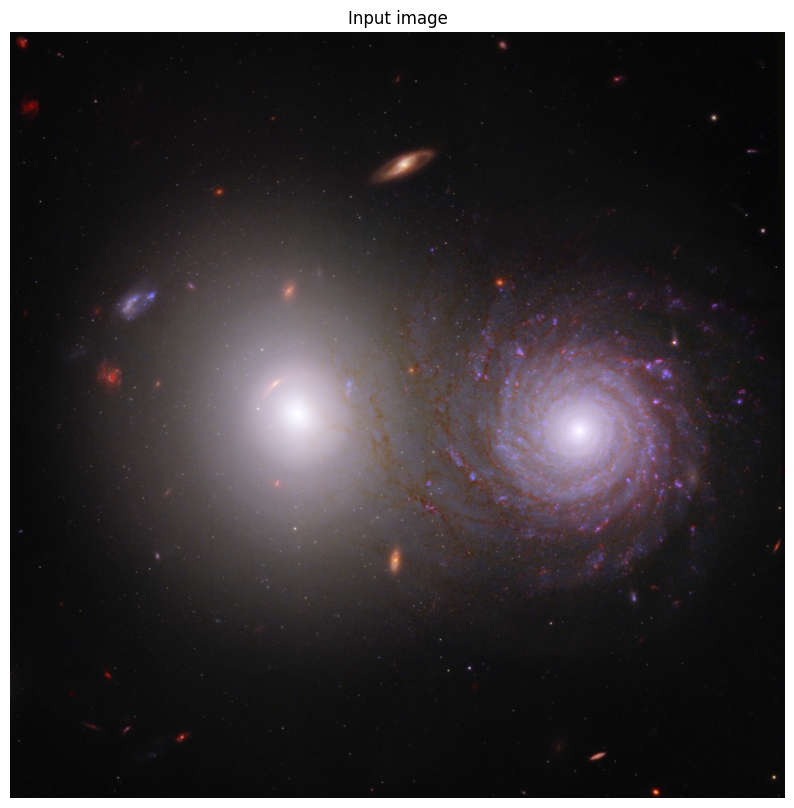

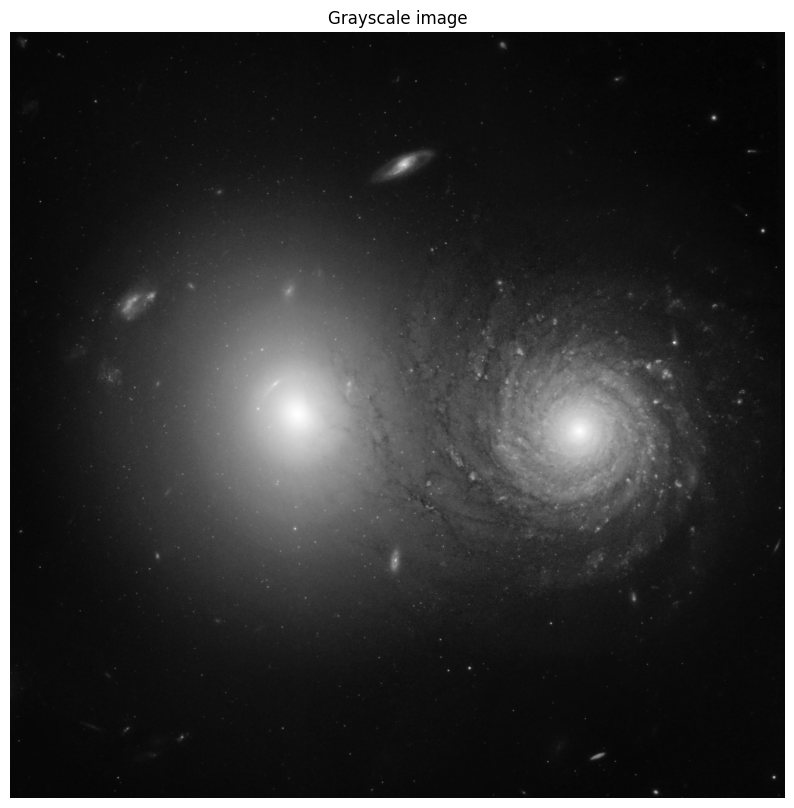

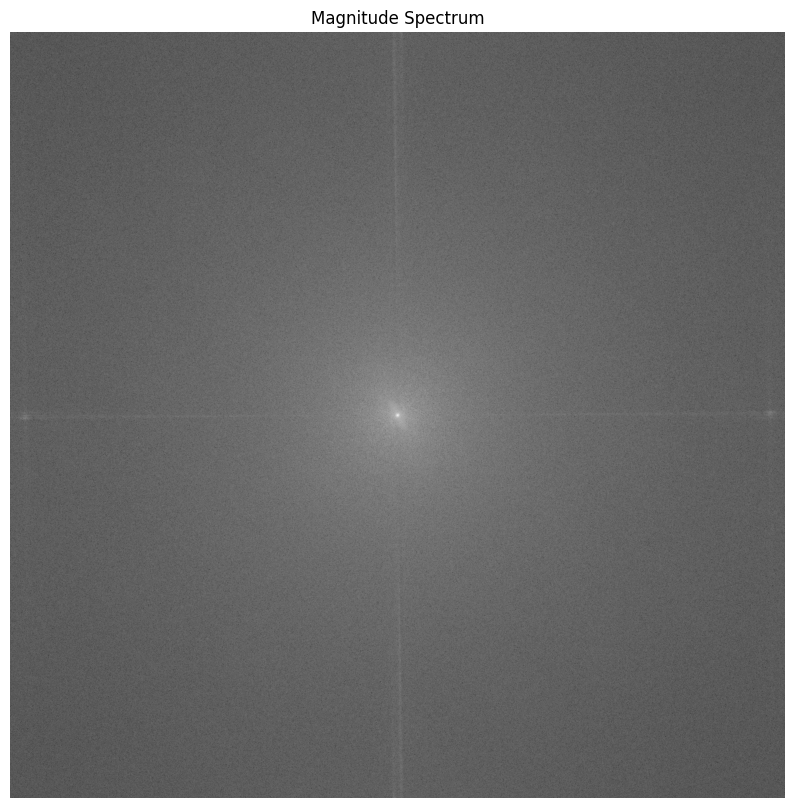

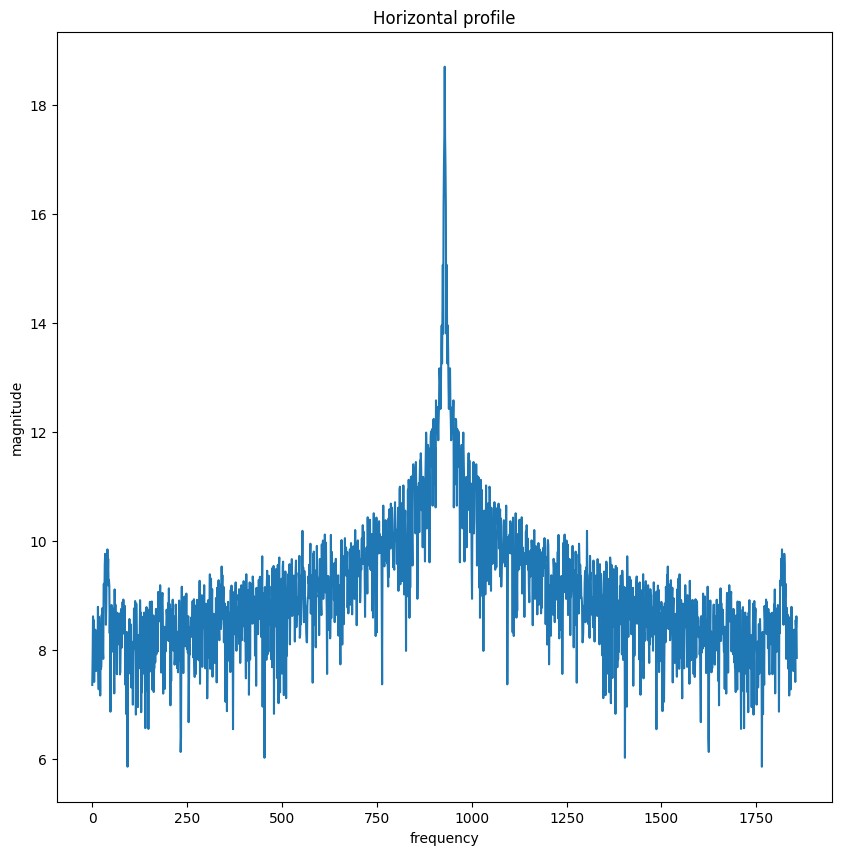

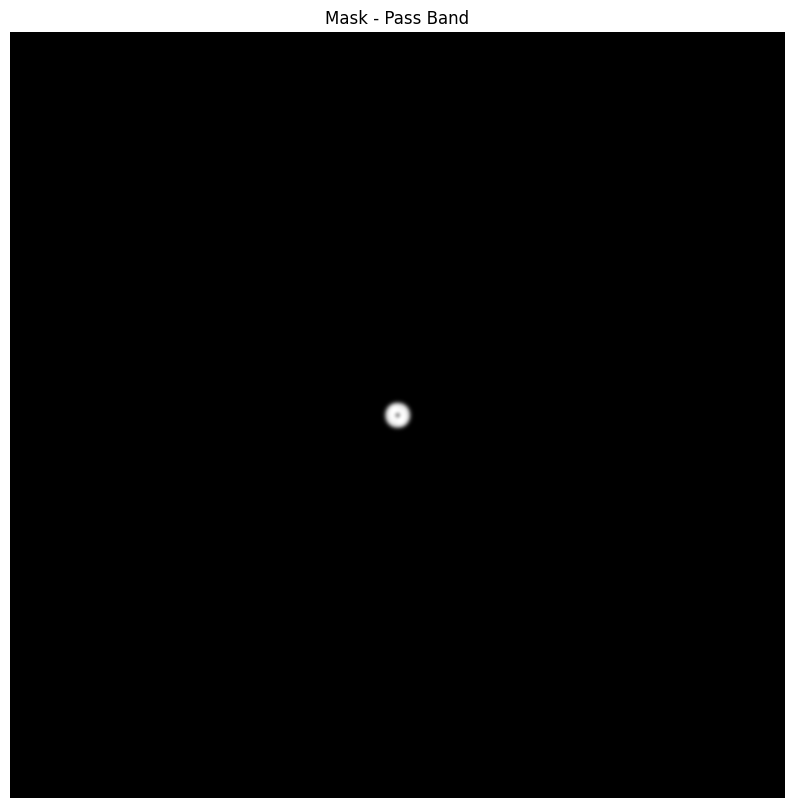

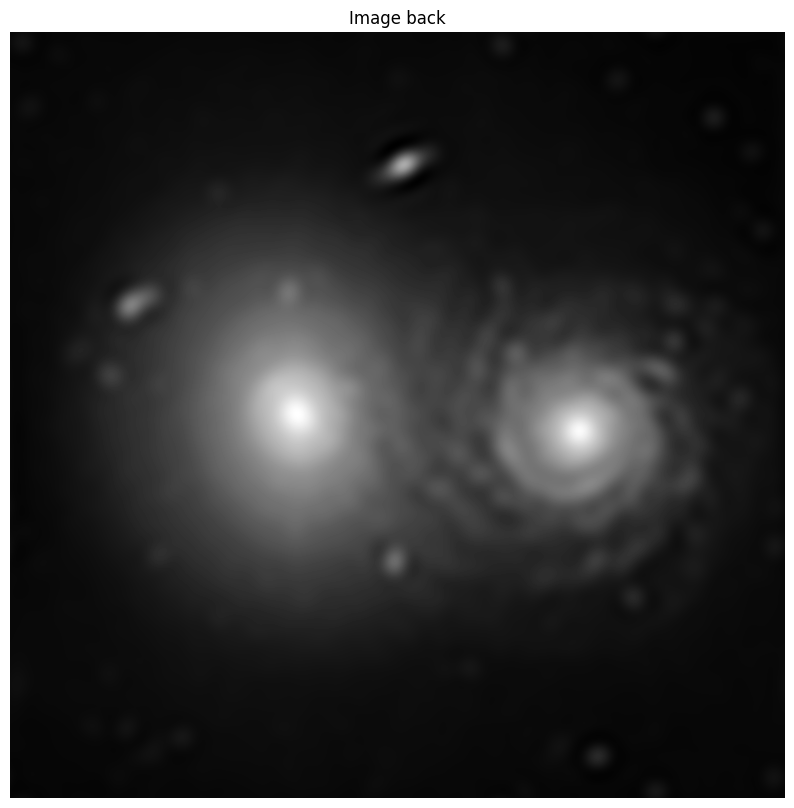

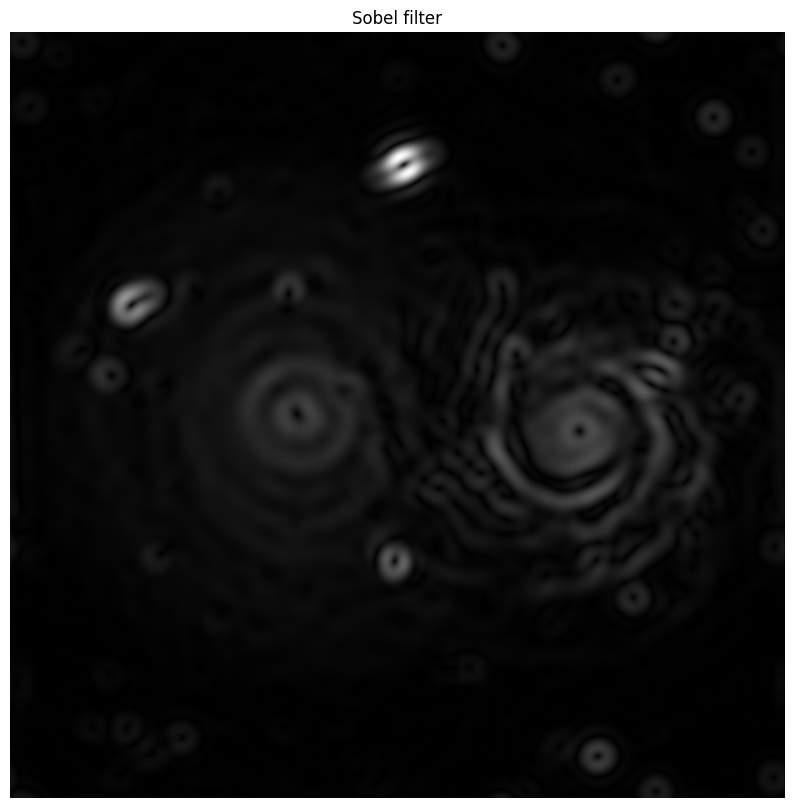

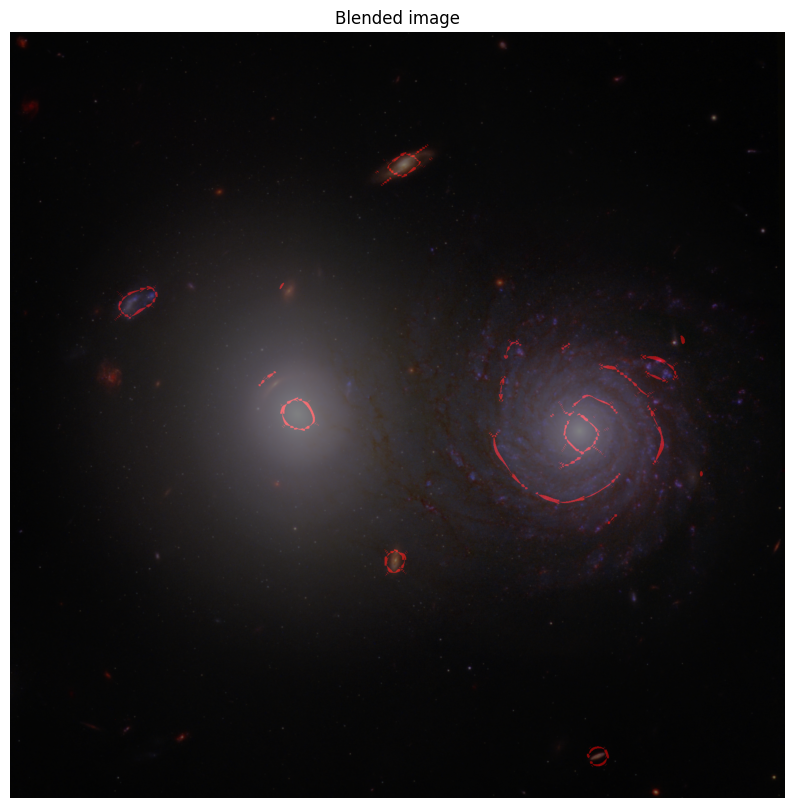

()

In [8]:
teste.run()